# Time Series Anomaly Detection
__Thursday 11/5/2020__

### Dataset: Codeup curriculum access logs
Our dataset contains approximately 3 years of unique timestamped access events to Codeup's cirriculum. Let's look at the definitions of each feature in our dataset.

|Feature | Description | datatype |
| :------ | :----------- | :---- |
| `datetime` | Index of the dataset. The date and time a page was viewed by a user | DatetimeIndex |
| `page_viewed` | The content the user accessed | object |
| `user_id` | The user who accessed the curriculum | int64 |
| `cohort_id` | The cohort the user is assigned to | int 64 |
| `ip` | The ip address the user is using to access the curriculum | object |

1. The context
2. Questions to ask
3. Which visualizations to use
4. What type of statistical tests we can perform.


### Exercises
Discover users who are accessing our curriculum pages way beyond the end of their codeup time.

### Questions
1. What would the dataframe look like?
> Use time series method for detecting anomalies, like exponential moving average with %b.

2. Bonus: Can you label students who are viewing both the web dev and data science curriculum?
> * Can you label students by the program they are in?
> * Can you label users by student vs. staff?
> * What are Zach, Maggie, Faith, and Ryan's ids?

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns

# import data wrangle functions
import main
import acquire
import prepare

# Wrangle

In [2]:
# load the dataset
df = acquire.get_cohort_log_data()

In [3]:
df = prepare.prep_curriculum_log_data(df)

In [4]:
print(f'There are {df.shape[0]:,} rows and {df.shape[1]} features in the dataset.')
# display the first 5 rows
df.head()

There are 719,459 rows and 4 features in the dataset.


,page_viewed,user_id,cohort_id,ip
datetime,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719459 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   page_viewed  719459 non-null  object
 1   user_id      719459 non-null  int64 
 2   cohort_id    719459 non-null  int64 
 3   ip           719459 non-null  object
dtypes: int64(2), object(2)
memory usage: 27.4+ MB


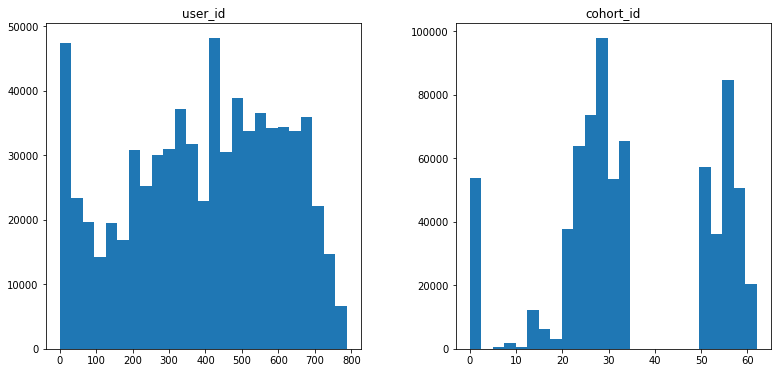

In [6]:
df.hist(figsize=(13, 6),
        grid=False,
        bins=25);

# Exploratory Data Analysis

### Questions
1. 
2. 
3. 
4. 
5. 
6. 
7. 

In [7]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

print(f'Train size: {len(train) / len(df):.2%}')
print(f'Validate size: {len(validate) / len(df):.2%}')
print(f'Test size: {len(test) / len(df):.2%}')

Train size: 50.00%
Validate size: 30.00%
Test size: 20.00%


In [8]:
train_agg = train.groupby(['datetime', 'cohort_id'])['user_id'] \
                    .nunique() \
                    .reset_index() \
                    .rename(index=str, 
                            columns={'user_id': 'users_viewed'}) \
                    .set_index('datetime')

In [9]:
train_agg.head()

,cohort_id,users_viewed
datetime,,
2018-01-26 09:55:03,8,1
2018-01-26 09:56:02,8,1
2018-01-26 09:56:05,8,1
2018-01-26 09:56:06,8,1
2018-01-26 09:56:24,22,1


In [18]:
# create hourly aggregated datasets
train_hourly_1hr = train_agg.resample('H').users_viewed.agg(['sum'])
train_hourly_1hr.rename(columns={'sum': 'times_viewed'}, inplace=True)

train_hourly_1hr['hour'] = train_hourly_1hr.index.hour
train_hourly_1hr['access_type'] = pd.cut(train_hourly_1hr['hour'],
                                         bins=[0, 9, 17, 24],
                                         labels=['Before Class', 'During Class', 'After Class'])

# create daily aggregated datasets
train_daily_1d = train_agg.resample('D').users_viewed.agg(['sum'])
train_daily_1d.rename(columns={'sum': 'times_viewed'}, inplace=True)
train_daily_1d['day_of_week'] = train_daily_1d.index.day_name()

# create  weekely aggregated datasets
train_weekly_1w = train_agg.resample('W').users_viewed.agg(['sum'])
train_weekly_1w.rename(columns={'sum': 'times_viewed'}, inplace=True)
train_weekly_1w['week_num'] = train_weekly_1w.index.isocalendar().week

# Hourly Logs

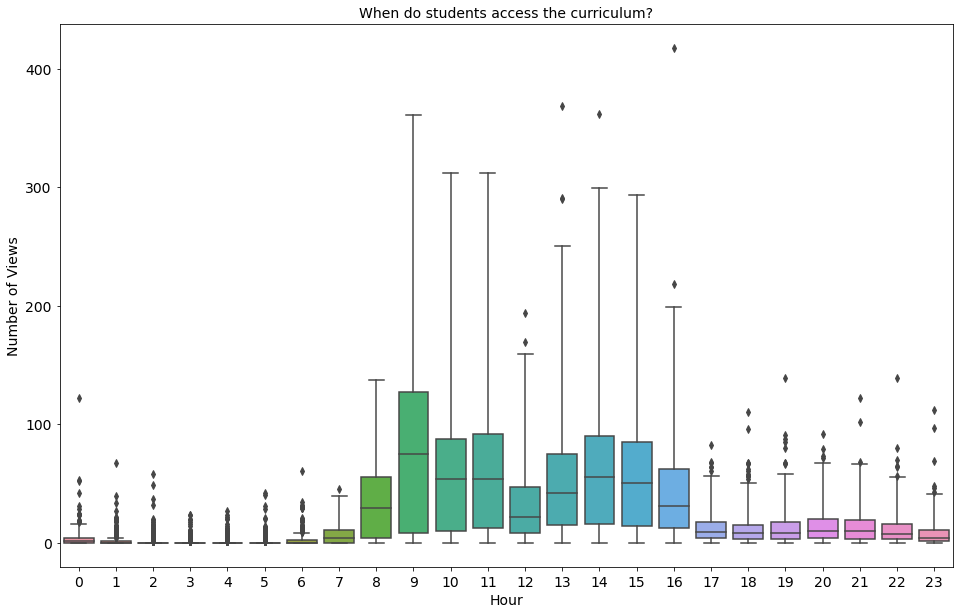

In [19]:
plt.figure(figsize=(16,10))
sns.boxplot(x=train_hourly_1hr['hour'],
            y=train_hourly_1hr.times_viewed,
            whis=3)
plt.title('When do students access the curriculum?', fontsize=14)
plt.tick_params(labelsize=14, pad=5)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Number of Views', fontsize=14);

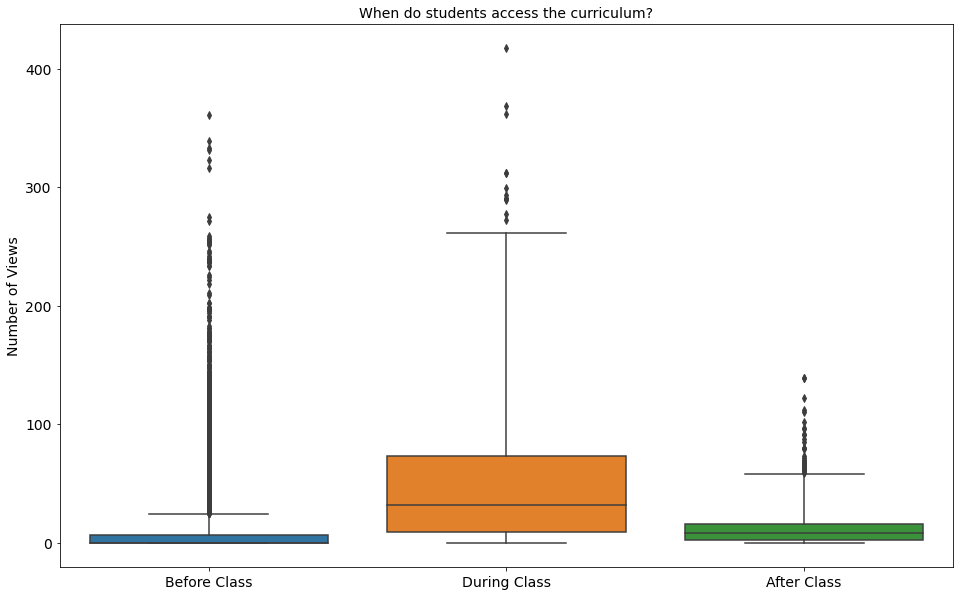

In [20]:
plt.figure(figsize=(16,10))
sns.boxplot(x=train_hourly_1hr.access_type,
            y=train_hourly_1hr.times_viewed,
            whis=3)
plt.title('When do students access the curriculum?', fontsize=14)
plt.tick_params(labelsize=14, pad=5)
plt.xlabel('')
plt.ylabel('Number of Views', fontsize=14);

In [21]:
train_hourly_1hr.head()

,times_viewed,hour,access_type
datetime,,,
2018-01-26 09:00:00,11,9,Before Class
2018-01-26 10:00:00,62,10,During Class
2018-01-26 11:00:00,101,11,During Class
2018-01-26 12:00:00,27,12,During Class
2018-01-26 13:00:00,52,13,During Class


# Daily Logs

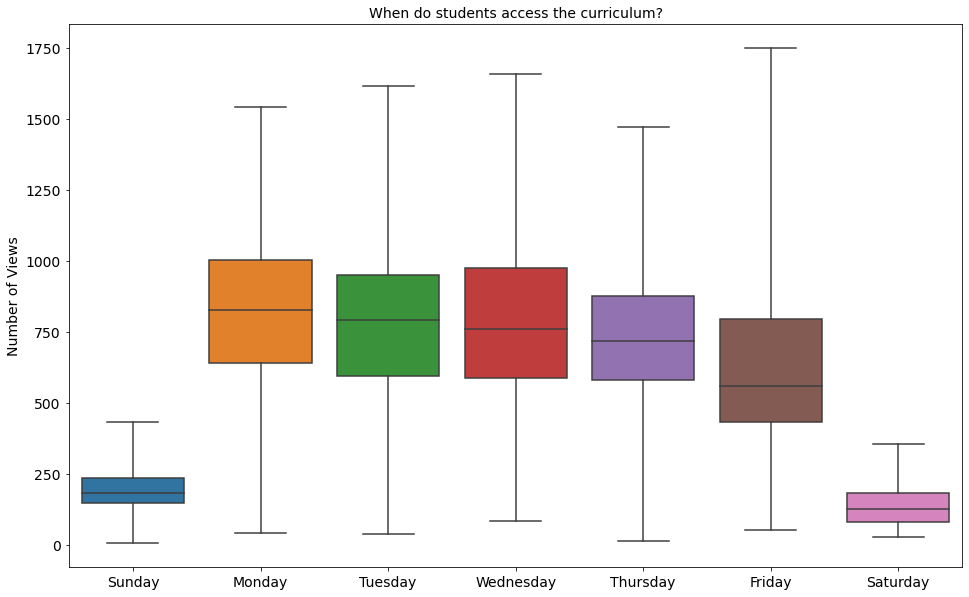

In [22]:
plt.figure(figsize=(16,10))
sns.boxplot(x=train_daily_1d.day_of_week,
            y=train_daily_1d['times_viewed'],
            order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
            whis=3)
plt.title('When do students access the curriculum?', fontsize=14)
plt.tick_params(labelsize=14, pad=5)
plt.xlabel('')
plt.ylabel('Number of Views', fontsize=14);

In [23]:
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [16]:
compute_entropy(df_agg.users_viewed)

NameError: name 'df_agg' is not defined